### 1. 라이브러리 불러오고 데이터 분석하기

In [19]:
#xgboost 사용하기 위해 설치 진행.

In [1]:
!pip install xgboost --quiet

In [2]:
from xgboost import XGBRegressor

In [3]:
#필요한 라이브러리 불러옴.
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [4]:
data = pd.read_csv("diamonds.csv") #데이터 가져오기
data.head() #5번째 행까지 데이터 보기

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [5]:
data = data.drop(columns=["Unnamed: 0"], errors="ignore") #특징이 아닌 첫번째 데이터 삭제
data.head() #5번째 행까지 데이터 보기

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [6]:
print("\n데이터 요약 정보:\n")
print(data.info())  # 데이터 타입 확인


데이터 요약 정보:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   carat    53940 non-null  float64
 1   cut      53940 non-null  object 
 2   color    53940 non-null  object 
 3   clarity  53940 non-null  object 
 4   depth    53940 non-null  float64
 5   table    53940 non-null  float64
 6   price    53940 non-null  int64  
 7   x        53940 non-null  float64
 8   y        53940 non-null  float64
 9   z        53940 non-null  float64
dtypes: float64(6), int64(1), object(3)
memory usage: 4.1+ MB
None


In [7]:
print("\n기술 통계 정보:\n")
print(data.describe())  # 수치형 변수 통계


기술 통계 정보:

              carat         depth         table         price             x  \
count  53940.000000  53940.000000  53940.000000  53940.000000  53940.000000   
mean       0.797940     61.749405     57.457184   3932.799722      5.731157   
std        0.474011      1.432621      2.234491   3989.439738      1.121761   
min        0.200000     43.000000     43.000000    326.000000      0.000000   
25%        0.400000     61.000000     56.000000    950.000000      4.710000   
50%        0.700000     61.800000     57.000000   2401.000000      5.700000   
75%        1.040000     62.500000     59.000000   5324.250000      6.540000   
max        5.010000     79.000000     95.000000  18823.000000     10.740000   

                  y             z  
count  53940.000000  53940.000000  
mean       5.734526      3.538734  
std        1.142135      0.705699  
min        0.000000      0.000000  
25%        4.720000      2.910000  
50%        5.710000      3.530000  
75%        6.540000     

In [8]:
print("\n결측치 확인:")
print(data.isnull().sum())


결측치 확인:
carat      0
cut        0
color      0
clarity    0
depth      0
table      0
price      0
x          0
y          0
z          0
dtype: int64


In [9]:
# 중복된 행 확인
duplicates = data.duplicated()
print(f"중복된 데이터 개수: {duplicates.sum()}")

# 중복된 데이터 제거
print(f"중복 제거 전 데이터 크기: {data.shape}")
data = data.drop_duplicates()
print(f"중복 제거 후 데이터 크기: {data.shape}")

중복된 데이터 개수: 146
중복 제거 전 데이터 크기: (53940, 10)
중복 제거 후 데이터 크기: (53794, 10)


### Attribute Information


가격:
미국 달러(\$326--\$18,823)

캐럿 무게:
다이아몬드의 무게 (0.2--5.01)

컷 품질:
컷의 품질 (Fair, Good, Very Good, Premium, Ideal)

색상:
다이아몬드 색상, J (최악)에서 D (최고)까지

투명도:
다이아몬드의 투명도 측정 (I1 (최악), SI2, SI1, VS2, VS1, VVS2, VVS1, IF (최고))

x:
길이 (mm) (0--10.74)

y:
너비 (mm) (0--58.9)

z:
깊이 (mm) (0--31.8)

깊이:
전체 깊이 비율 = z / 평균(x, y) = 2 * z / (x + y) (43--79)

테이블:
다이아몬드의 가장 넓은 부분에 대한 상단 너비 비율 (43--95)


### 2. 데이터 전처리
##### - cut(Fair, Good, Very Good, Premium, Ideal), 
##### - color(J~D),
##### - clarity(I1 (worst), SI2, SI1, VS2, VS1, VVS2, VVS1, IF (best)) 
##### 는 범주형 데이터이므로 원-핫 인코딩한다.

##### - x
##### - y
##### - z
##### 는 depth( = 2 * z / (x + y))에 포함되어 있으므로 제거.

In [10]:
data = pd.get_dummies(data, prefix = ['cut', 'color', 'clarity'], columns=['cut', 'color', 'clarity'])
data = data.drop(columns=['x', 'y', 'z'])

In [11]:
data.head()

,carat,depth,table,price,cut_Fair,cut_Good,cut_Ideal,cut_Premium,cut_Very Good,color_D,...,color_I,color_J,clarity_I1,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2
0,0.23,61.5,55.0,326,False,False,True,False,False,False,...,False,False,False,False,False,True,False,False,False,False
1,0.21,59.8,61.0,326,False,False,False,True,False,False,...,False,False,False,False,True,False,False,False,False,False
2,0.23,56.9,65.0,327,False,True,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
3,0.29,62.4,58.0,334,False,False,False,True,False,False,...,True,False,False,False,False,False,False,True,False,False
4,0.31,63.3,58.0,335,False,True,False,False,False,False,...,False,True,False,False,False,True,False,False,False,False


##### 최종 변수: carat, depth, table, 원핫 인코딩된 cut, color, clarity
##### target 값: price

In [12]:
var = [x for x in data.columns if x not in 'price'] ## Removing our target variable

In [13]:
print(len(var))

23


##### var 변수는 target값을 제외한 특성들. 개수는 23개임을 알 수 있음.

### 3. Dataset 학습데이터 및 테스트 데이터 세트로 분할하기

In [14]:
help(train_test_split)

Help on function train_test_split in module sklearn.model_selection._split:

train_test_split(*arrays, test_size=None, train_size=None, random_state=None, shuffle=True, stratify=None)
    Split arrays or matrices into random train and test subsets.
    
    Quick utility that wraps input validation,
    ``next(ShuffleSplit().split(X, y))``, and application to input data
    into a single call for splitting (and optionally subsampling) data into a
    one-liner.
    
    Read more in the :ref:`User Guide <cross_validation>`.
    
    Parameters
    ----------
    *arrays : sequence of indexables with same length / shape[0]
        Allowed inputs are lists, numpy arrays, scipy-sparse
        matrices or pandas dataframes.
    
    test_size : float or int, default=None
        If float, should be between 0.0 and 1.0 and represent the proportion
        of the dataset to include in the test split. If int, represents the
        absolute number of test samples. If None, the value is set to

In [15]:
X_train, X_test, y_train, y_test = train_test_split(data[var], data['price'], test_size=0.2, random_state=42)

In [22]:
n = int(len(X_train)*0.8) ## Let's use 80% to train and 20% to eval

In [23]:
X_train_fit, X_train_eval, y_train_fit, y_train_eval = X_train[:n], X_train[n:], y_train[:n], y_train[n:]

In [16]:
print(f'train samples: {len(X_train)}\ntest samples: {len(X_test)}')

train samples: 43035
test samples: 10759


### 4. 모델 훈련

In [24]:
xgb_model = xgb.XGBRegressor(
    n_estimators=1000,      # 최대 트리 개수
    learning_rate=0.05,     # 학습 속도
    max_depth=6,            # 최대 트리 깊이
    random_state=42
)

xgb_model.fit(X_train_fit, y_train_fit, eval_set=[(X_train_eval,y_train_eval)], early_stopping_rounds=50, verbose=True)

TypeError: XGBModel.fit() got an unexpected keyword argument 'early_stopping_rounds'

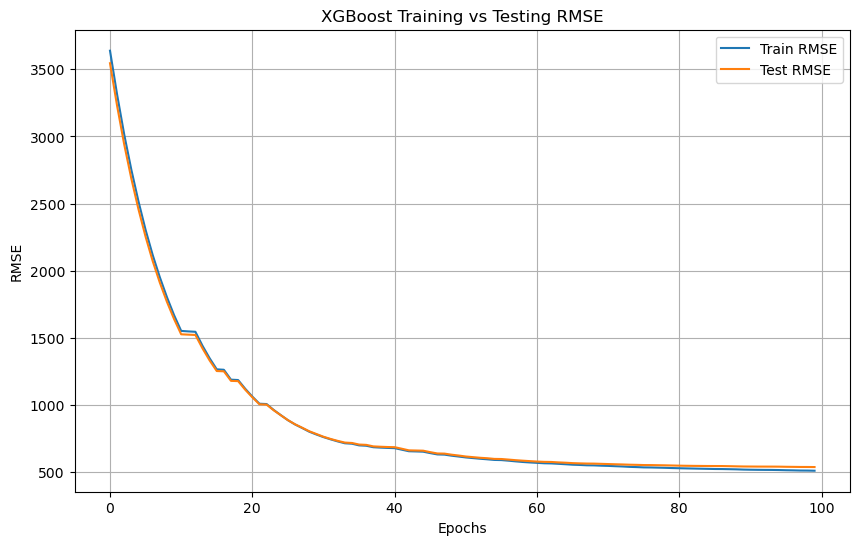

In [18]:
# 시각화
results = xgb_model.evals_result()
epochs = len(results['validation_0']['rmse'])
x_axis = range(0, epochs)

plt.figure(figsize=(10, 6))
plt.plot(x_axis, results['validation_0']['rmse'], label='Train RMSE')
plt.plot(x_axis, results['validation_1']['rmse'], label='Test RMSE')
plt.xlabel('Epochs')
plt.ylabel('RMSE') # Root Mean Squared Error: 예측 값과 실제 값 간의 차이 측정
plt.title('XGBoost Training vs Testing RMSE')
plt.legend()
plt.grid()
plt.show()

In [ ]:
!pip uninstall xgboost